In [3]:
from transformers import AutoModel, AutoTokenizer
import torch
from monkeypatch.progressive_attention_roberta import patch
patch()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import our models. The package will take care of downloading the models automatically

model_id = "princeton-nlp/unsup-simcse-roberta-large"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained("/workspace/best_model").to(device)

torch.Size([7, 1024])
torch.Size([7, 1024])


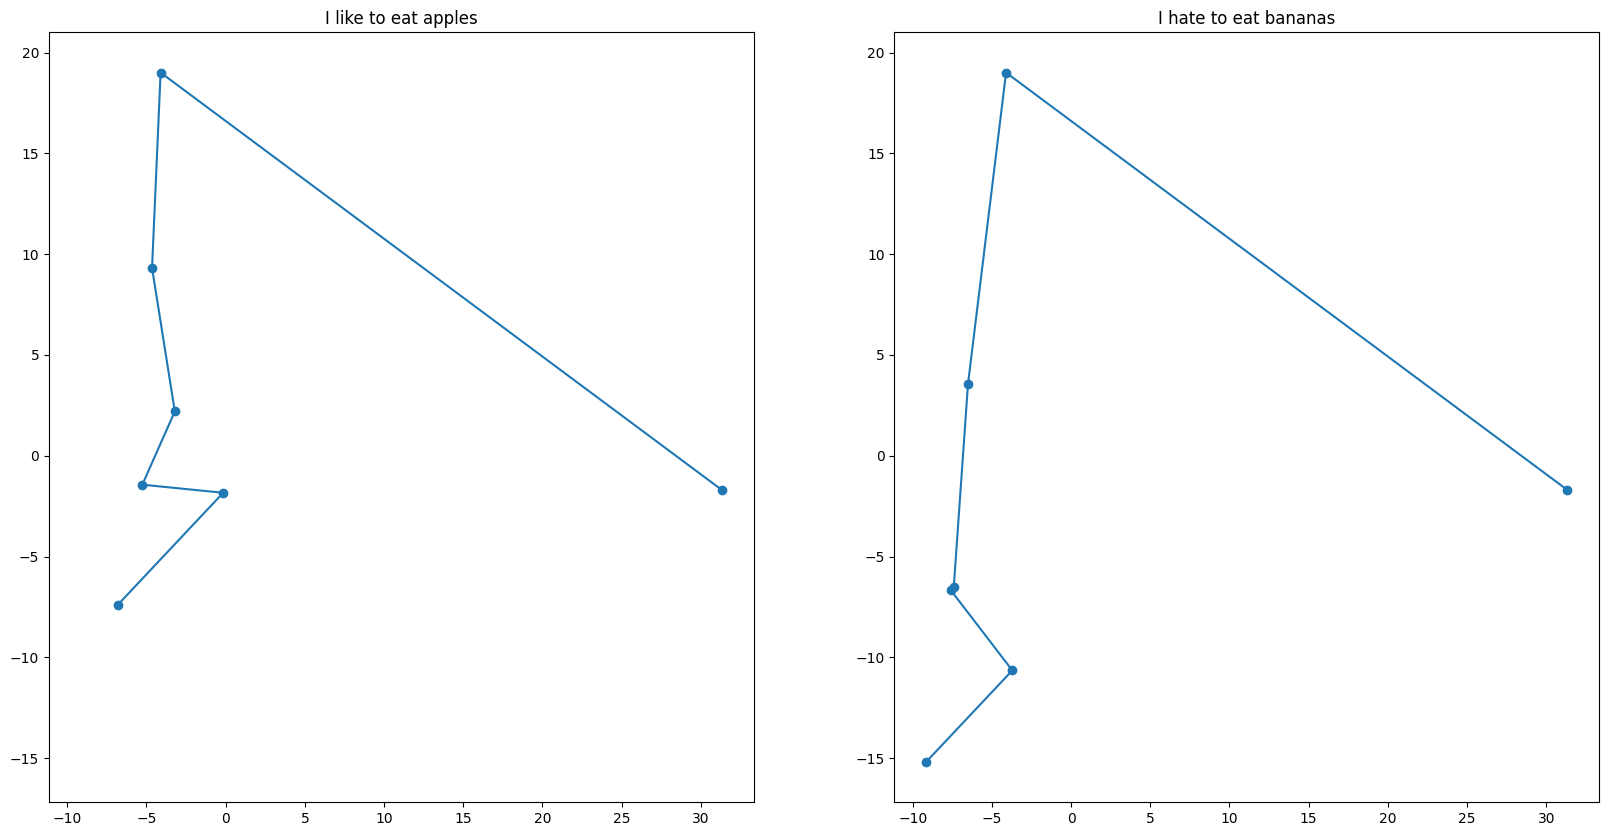

In [4]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
model.eval()

def evaluate(texts):
    outputs = []
    labels = []
    for i, text in enumerate(texts):
        input_ids = tokenizer(text, return_tensors="pt").to(device)
        with torch.no_grad():
            output = model(**input_ids).last_hidden_state[0]
            print(output.shape)
            outputs.append(output.cpu().numpy())
            labels.append(np.ones(output.shape[0]) * i)

    np_outputs = np.concatenate(outputs, axis=0)
    labels = np.concatenate(labels, axis=0)

    outputs_2d = pca.fit_transform(np_outputs)

    min_x, max_x = outputs_2d[:, 0].min(), outputs_2d[:, 0].max()
    min_y, max_y = outputs_2d[:, 1].min(), outputs_2d[:, 1].max()

    fig, axes = plt.subplots(1, len(texts), figsize=(20, 10))

    current_start_idx = 0
    for i, text in enumerate(texts):
        axes[i].set_xlim(min_x, max_x)
        axes[i].set_ylim(min_y, max_y)
        axes[i].set_title(text)
        current_len = outputs[i].shape[0]
        axes[i].scatter(outputs_2d[current_start_idx:current_start_idx + current_len, 0], outputs_2d[current_start_idx:current_start_idx + current_len, 1])
        axes[i].plot(outputs_2d[current_start_idx:current_start_idx + current_len, 0], outputs_2d[current_start_idx:current_start_idx + current_len, 1])
        axes[i].set_xlim(min_x - 2, max_x + 2)
        axes[i].set_ylim(min_y - 2, max_y + 2)

        current_start_idx += current_len
    plt.show()

evaluate([
    "I like to eat apples",
    "I hate to eat bananas",
])

In [5]:
batch_size = 32
EPCOH = 1
LR = 1e-5
TEMPERATURE = 0.05

In [6]:
# Creating a dictionary to label the emotions from -1 (worst) to 1 (best)
emotions_scores = {
    'sentimental': 0.5,       # Positive, but with a hint of sadness
    'surprised': 0.3,         # Can be positive or negative, but often slightly positive
    'impressed': 0.7,         # Positive
    'lonely': -0.8,           # Negative
    'ashamed': -0.9,          # Very negative
    'guilty': -0.8,           # Negative
    'nostalgic': 0.4,         # Mostly positive, with a touch of sadness
    'content': 0.8,           # Positive
    'furious': -0.9,          # Very negative
    'afraid': -0.8,           # Negative
    'joyful': 1.0,            # Extremely positive
    'anxious': -0.7,          # Negative
    'angry': -0.8,            # Negative
    'excited': 0.9,           # Very positive
    'confident': 0.8,         # Positive
    'trusting': 0.6,          # Positive
    'disappointed': -0.7,     # Negative
    'sad': -0.9,              # Very negative
    'devastated': -1.0,       # Extremely negative
    'proud': 0.9,             # Very positive
    'apprehensive': -0.6,     # Negative
    'caring': 0.7,            # Positive
    'anticipating': 0.5,      # Can be positive or negative, generally positive
    'embarrassed': -0.7,      # Negative
    'jealous': -0.7,          # Negative
    'hopeful': 0.8,           # Positive
    'disgusted': -0.8,        # Negative
    'prepared': 0.6,          # Positive, indicates readiness
    'grateful': 0.9,          # Very positive
    'faithful': 0.7,          # Positive
    'terrified': -0.9,        # Very negative
    'annoyed': -0.6           # Negative
}

In [7]:
from datasets import load_dataset
from sklearn.decomposition import PCA
from tqdm import tqdm

emotion_dataset = load_dataset("empathetic_dialogues", split="train")
emotion_df = emotion_dataset.to_pandas()
gruoped_df = emotion_df.groupby('conv_id').agg({'utterance': '\n'.join, 'context': 'last'})
gruoped_df.head()

num_batches = len(gruoped_df) // batch_size

input_ids = torch.zeros((num_batches, batch_size, 128), dtype=torch.long)
attention_masks = torch.zeros((num_batches, batch_size, 128), dtype=torch.long)
emotion_scores = torch.zeros((num_batches, batch_size), dtype=torch.float)

for i in tqdm(range(0, len(gruoped_df), batch_size)):
    if i // batch_size >= num_batches:
        break
    data = gruoped_df['utterance'][i:i+batch_size]
    data = list(data)
    data = tokenizer(data, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    input_ids[i//batch_size] = data['input_ids']
    attention_masks[i//batch_size] = data['attention_mask']
    emotion_score = gruoped_df['context'][i:i+batch_size].apply(lambda x: emotions_scores[x]).values
    emotion_scores[i//batch_size] = torch.tensor(emotion_score)

input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)
emotion_scores = emotion_scores.to(device)

Generating train split:  73%|███████▎  | 56118/76673 [00:06<00:02, 8306.36 examples/s]


KeyboardInterrupt: 

In [ ]:
# !python -m pip install plotly

In [ ]:
from datasets import load_dataset
from sklearn.decomposition import PCA
from tqdm import tqdm

emotion_dataset = load_dataset("empathetic_dialogues", split="train")
emotion_df = emotion_dataset.to_pandas()
gruoped_df = emotion_df.groupby('conv_id').agg({'utterance': '\n'.join, 'context': 'last'})

num_batches = len(gruoped_df) // batch_size

input_ids = torch.zeros((num_batches, batch_size, 128), dtype=torch.long)
attention_masks = torch.zeros((num_batches, batch_size, 128), dtype=torch.long)
emotion_scores = torch.zeros((num_batches, batch_size), dtype=torch.float)

for i in tqdm(range(0, len(gruoped_df), batch_size)):
    if i // batch_size >= num_batches:
        break
    data = gruoped_df['utterance'][i:i+batch_size]
    data = list(data)
    data = tokenizer(data, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    input_ids[i//batch_size] = data['input_ids']
    attention_masks[i//batch_size] = data['attention_mask']
    emotion_score = gruoped_df['context'][i:i+batch_size].apply(lambda x: emotions_scores[x]).values
    emotion_scores[i//batch_size] = torch.tensor(emotion_score)

input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)
emotion_scores = emotion_scores.to(device)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("abokbot/wikipedia-first-paragraph", split="train[:100000]")
dataset = dataset.filter(lambda x: len(x["text"]) > 600)

len(dataset)

In [ ]:
num_batches = len(dataset) // batch_size

input_ids = torch.zeros((num_batches, batch_size, 128), dtype=torch.long)
attention_masks = torch.zeros((num_batches, batch_size, 128), dtype=torch.long)

for i in tqdm(range(0, len(dataset), batch_size)):
    if i // batch_size >= num_batches:
        break
    data = dataset['text'][i:i+batch_size]
    data = list(data)
    data = tokenizer(data, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    input_ids[i//batch_size] = data['input_ids']
    attention_masks[i//batch_size] = data['attention_mask']

input_ids = input_ids.to(device)
attention_masks = attention_masks.to(device)

In [ ]:
# evaluate
import numpy as np
import pandas as pd
# import plotly.express as px

evaluate_batches = input_ids.shape[0]
results = np.zeros((evaluate_batches * batch_size, 128, 1024))
model.eval()

for i in tqdm(range(evaluate_batches)):
    with torch.no_grad():
        output = model(input_ids[i], attention_masks[i]).last_hidden_state.detach().cpu().numpy()
        output /= np.linalg.norm(output, axis=-1, keepdims=True)

        results[i*batch_size:(i+1)*batch_size] = output
results = results.transpose(1, 0, 2)

In [ ]:
# pca = PCA(n_components=2)
# pca.fit(results.reshape(-1, 1024)[

# results_2d = pca.fit_transform(results.reshape(-1, 1024)).reshape(128, -1, 2)
# scores = emotion_scores.cpu().numpy().reshape(-1)

In [ ]:
i = 33

sentence = results[:, i]
similarity = sentence @ sentence.T

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.heatmap(similarity, vmin=-1, vmax=1, cmap="coolwarm")

print(dataset['text'][i])
plt.show()

In [ ]:
index = range(100)
pca = PCA(n_components=2)
# result_2d = pca.fit(results[:, 100])
for i in tqdm(index):
    result_2d = pca.fit_transform(results[:, i])

    smooth_factor = 20
    result_2d_x = np.convolve(result_2d[:, 0], np.ones(smooth_factor), 'valid') / smooth_factor
    result_2d_y = np.convolve(result_2d[:, 1], np.ones(smooth_factor), 'valid') / smooth_factor
    # result_2d = pca.transform(results[:, i])

    # print(dataset['text'][i])
    # plt.scatter(result_2d_x, result_2d_y, c=np.arange(128 - smooth_factor + 1), cmap="coolwarm")
    plt.plot(result_2d_x, result_2d_y, label=i)

plt.legend()
plt.show()

: 